In [2]:
#conda activate torch-xla-nightly
#export XRT_TPU_CONFIG="tpu_worker;0;$10.0.101.2:8470"
#git init
#git remote add origin https://github.com/nosound2/RSNA-Hemorrhage
#git pull origin master
#git config remote.origin.push HEAD
#gcloud config set compute/zone europe-west4-a
#gcloud auth login
#gcloud config set project endless-empire-239015
#pip install kaggle
#mkdir .kaggle
#gsutil cp gs://recursion-double-strand/kaggle-keys/kaggle.json ~/.kaggle
#chmod 600 /home/zahar_chikishev/.kaggle/kaggle.json
#kaggle competitions download rsna-intracranial-hemorrhage-detection -f stage_1_train.csv
#sudo apt install unzip
#unzip stage_1_train.csv.zip
#kaggle kernels output xhlulu/rsna-generate-metadata-csvs -p .
#gsutil cp gs://rsna-hemorrhage/yuvals/* .

#export XRT_TPU_CONFIG="tpu_worker;0;10.0.101.2:8470"; conda activate torch-xla-nightly; jupyter notebook

# 35.204.242.164

In [3]:
VERSION = 21

In [4]:
import sys

from pathlib import Path
from PIL import ImageDraw, ImageFont, Image
from matplotlib import patches, patheffects
import time
from random import randint
import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,log_loss
from scipy.stats import ks_2samp

import pdb

import scipy as sp
from tqdm import tqdm, tqdm_notebook

import os
import glob

import torch

CLOUD = not torch.cuda.is_available()
CLOUD_SINGLE = False

if not CLOUD:
    torch.cuda.current_device()

import torch.nn as nn
import torch.utils.data as D
import torch.nn.functional as F
import torch.utils as U

import torchvision
from torchvision import transforms as T
from torchvision import models as M

import matplotlib.pyplot as plt

if CLOUD:
    PATH = Path('/home/zahar_chikishev')
    PATH_WORK = Path('/home/zahar_chikishev/running')
else:
    PATH = Path('C:/StudioProjects/Hemorrhage')
    PATH_WORK = Path('C:/StudioProjects/Hemorrhage/running')

from collections import defaultdict, Counter
import random
import seaborn as sn

pd.set_option("display.max_columns", 100)

all_ich = ['any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural']
class_weights = 6.0*np.array([2,1,1,1,1,1])/7.0

if CLOUD:
    import torch_xla
    import torch_xla.distributed.data_parallel as dp
    import torch_xla.utils as xu
    import torch_xla.core.xla_model as xm
    
    from typing import Collection

In [5]:
if CLOUD:
    device = xm.xla_device()
    #device = 'cpu'
    MAX_DEVICES = 1 if CLOUD_SINGLE else 8
    bs = 100
else:
    device = 'cuda'
    #device = 'cpu'
    MAX_DEVICES = 1
    bs = 10

if CLOUD and (not CLOUD_SINGLE):
    devices = xm.get_xla_supported_devices(max_devices=MAX_DEVICES)

In [6]:
SEED = 2351

def setSeeds(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

setSeeds(SEED)
torch.backends.cudnn.deterministic = True

In [7]:
cols_cat, cols_float = pickle.load(open(PATH_WORK/'covs','rb'))
meta_cols = cols_cat + cols_float

In [8]:
if False:
    filename = PATH_WORK/'indexes_file.pkl'
    all_idx, train_ids, val_ids = pickle.load(open(filename,'rb'))

    train_md = pd.read_csv(PATH_WORK/'train_md.csv').sort_values(['SeriesInstanceUID','pos_idx'])
    train_md['img_id'] = train_md.SOPInstanceUID.str.split('_').apply(lambda x: x[1])

    trn_data = train_md.loc[train_md.img_id.isin(all_idx[train_ids])].reset_index(drop=True)
    val_data = train_md.loc[train_md.img_id.isin(all_idx[val_ids])].reset_index(drop=True)

    assert len(trn_data.SeriesInstanceUID.unique()) + len(val_data.SeriesInstanceUID.unique()) \
        == len(train_md.SeriesInstanceUID.unique())

    assert len(trn_data.PatientID.unique()) + len(val_data.PatientID.unique()) \
        >= len(train_md.PatientID.unique())

    ids_df = pd.DataFrame(all_idx, columns = ['img_id'])
    ids_df = ids_df.join(train_md[['img_id','SeriesInstanceUID','pos_idx']].set_index('img_id'), on = 'img_id')

    assert len(ids_df.SeriesInstanceUID.unique()) == 19530
    
    pickle.dump((trn_data,val_data,ids_df), open(PATH_WORK/'train.post.processed.1','wb'))
else:
    trn_data,val_data,ids_df = pickle.load(open(PATH_WORK/'train.post.processed.1','rb'))

In [9]:
if False:
    test_md = pd.read_csv(PATH_WORK/'test_md.csv').sort_values(['SeriesInstanceUID','pos_idx'])
    test_md['img_id'] = test_md.SOPInstanceUID.str.split('_').apply(lambda x: x[1])

    filename = PATH_WORK/'test_indexes.pkl'
    test_ids = pickle.load(open(filename,'rb'))

    test_ids_df = pd.DataFrame(test_ids, columns = ['img_id'])
    test_ids_df = test_ids_df.join(test_md[['img_id','SeriesInstanceUID','pos_idx']].set_index('img_id'), on = 'img_id')

    assert len(test_ids_df.SeriesInstanceUID.unique()) == 2214
    
    pickle.dump((test_md,test_ids_df), open(PATH_WORK/'test.post.processed.1','wb'))
else:
    test_md,test_ids_df = pickle.load(open(PATH_WORK/'test.post.processed.1','rb'))

In [10]:
if False:
    print(pd.concat([test_md[meta_cols].mean(0),
                     trn_data[meta_cols].mean(0),
                     val_data[meta_cols].mean(0)], axis=1))

# Pre-processing

In [11]:
if False:
    filename = PATH_WORK/'model_Densenet161_3_vehrsion_basic_classifier_type_features_train_split_2.pkl'
    feats = pickle.load(open(filename,'rb'))

    for series_id in tqdm(ids_df.SeriesInstanceUID.unique()):
        mask = torch.BoolTensor(ids_df.SeriesInstanceUID.values == series_id)
        feats_id = feats[mask]
        pickle.dump(feats_id, open(PATH_WORK/'features/densenet161_v3/train/{}'.format(series_id),'wb'))


    filename = PATH_WORK/'model_Densenet161_3_vehrsion_basic_classifier_type_features_test_split_2.pkl'
    feats = pickle.load(open(filename,'rb'))

    for series_id in tqdm(test_ids_df.SeriesInstanceUID.unique()):
        mask = torch.BoolTensor(test_ids_df.SeriesInstanceUID.values == series_id)
        feats_id = feats[mask]
        pickle.dump(feats_id, open(PATH_WORK/'features/densenet161_v3/test/{}'.format(series_id),'wb'))

# Dataset

In [12]:
#path = PATH_WORK/'features/densenet161_v3/train/ID_000a935543'
#feats1 = pickle.load(open(path,'rb'))

In [13]:
all_black = '006d4432e'

path = PATH_WORK/'features/densenet161_v3/train/ID_992b567eb6'
black_feats = pickle.load(open(path,'rb'))[41]

#black_feats = torch.zeros(black_feats.shape)

In [14]:
class RSNA_DataSet(D.Dataset):
    def __init__(self, metadata, ids_df, mode='train', bs=None):
        
        super(RSNA_DataSet, self).__init__()
        
        md = metadata.copy()
        md = md.reset_index(drop=True)
        series = md.SeriesInstanceUID.unique()
        
        samples_add = 0
        if (mode != 'train') and not DATA_SMALL:
            batch_num = -((-len(series))//(bs*MAX_DEVICES))
            samples_add = batch_num*bs*MAX_DEVICES - len(series)
            print('adding dummy serieses', samples_add)
        
        #self.records = df.to_records(index=False)
        self.mode = mode
        self.real = np.concatenate([np.repeat(True,len(series)),np.repeat(False,samples_add)])
        self.series = np.concatenate([series,np.repeat(series[0],samples_add)])
        self.metadata = md
        self.ids_df = ids_df
    
    def __getitem__(self, index):
        
        series_id = self.series[index]
        df = self.metadata.loc[self.metadata.SeriesInstanceUID == series_id].reset_index(drop=True)
        
        folder = 'test' if self.mode == 'test' else 'train'
        path = PATH_WORK/'features/densenet161_v3/{}/{}'.format(folder,series_id)
        feats = pickle.load(open(path,'rb'))
        ids_df_sub = self.ids_df.loc[self.ids_df.SeriesInstanceUID.values == series_id]
        
        if feats.shape[0] > len(df):
            mask_dup = ~ids_df_sub.img_id.duplicated().values
            ids_df_sub = ids_df_sub.loc[mask_dup]
            feats = feats[torch.BoolTensor(mask_dup)]
        
        assert feats.shape[0] == len(df)
        assert len(ids_df_sub) == len(df)
        assert np.all(ids_df_sub.img_id.isin(df.img_id).values)
        order = np.argsort(ids_df_sub.pos_idx.values)
        assert np.all(ids_df_sub.img_id.values[order] == df.img_id.values)
        feats = feats[torch.LongTensor(order)]
        
        feats = torch.cat([feats, torch.Tensor(df[meta_cols].values)], dim=1)
        target = torch.Tensor(df[all_ich].values)
        
        offset = np.random.randint(0, 61 - feats.shape[0])
        #offset = 0
        if offset > 0:
            dummy_row = torch.cat([black_feats, torch.Tensor(df.head(1)[meta_cols].values).squeeze()])
            #dummy_row = torch.cat([black_feats, torch.zeros(len(meta_cols))])
            feats = torch.cat([dummy_row.repeat(offset,1), feats], dim=0)
            target = torch.cat([torch.zeros((offset, len(all_ich))), target], dim=0)
        if (60 - len(df) - offset) > 0:
            dummy_row = torch.cat([black_feats, torch.Tensor(df.tail(1)[meta_cols].values).squeeze()])
            #dummy_row = torch.cat([black_feats, torch.zeros(len(meta_cols))])
            feats = torch.cat([feats, dummy_row.repeat(60 - len(df) - offset,1)], dim=0)
            target = torch.cat([target, torch.zeros((60 - len(df) - offset, len(all_ich)))], dim=0)
        
        assert feats.shape[0] == 60
        assert target.shape[0] == 60
        
        feats = feats.transpose(1,0)
        
        idx = index
        if not self.real[index]: idx = -1
        
        if self.mode == 'train':
            return feats, target
        else:
            return feats, target, idx, offset
    
    def __len__(self):
        return len(self.series) if not DATA_SMALL else int(0.01*len(self.series))

In [15]:
def getCurrentBatch(fold=0):
    sel_batch = None
    for filename in os.listdir(PATH_WORK/'models'):
        splits = filename.split('.')
        if int(splits[2][1]) != fold: continue
        if int(splits[3][1:]) != VERSION: continue
        if sel_batch is None:
            sel_batch = int(splits[1][1:])
        else:
            sel_batch = max(sel_batch, int(splits[1][1:]))
    return sel_batch

def modelFileName(fold=0, batch = 1, return_last = False, return_next = False):
    sel_batch = batch
    if return_last or return_next:
        sel_batch = getCurrentBatch(fold)
        if return_last and sel_batch is None:
            return None
        if return_next:
            if sel_batch is None: sel_batch = 1
            else: sel_batch += 1
    
    return 'model.b{}.f{}.v{}'.format(sel_batch, fold, VERSION)

# Model

In [16]:
class _Loss(nn.Module):
    def __init__(self, size_average=None, reduce=None, reduction='mean'):
        super(_Loss, self).__init__()
        if size_average is not None or reduce is not None:
            self.reduction = _Reduction.legacy_get_string(size_average, reduce)
        else:
            self.reduction = reduction

class BCEWithLogitsLoss(_Loss):
    __constants__ = ['weight', 'pos_weight', 'reduction']

    def __init__(self, weight=None, size_average=None, reduce=None, reduction='mean', pos_weight=None):
        super(BCEWithLogitsLoss, self).__init__(size_average, reduce, reduction)
        self.register_buffer('weight', weight)
        self.register_buffer('pos_weight', pos_weight)
    
    def forward(self, input, target):
        #((torch.log(1+torch.exp(input)) - target*input)*self.weight).mean()
        return F.binary_cross_entropy_with_logits(input.squeeze(), target,
                                                  self.weight,
                                                  pos_weight=self.pos_weight,
                                                  reduction=self.reduction)

In [17]:
class FeatProduct(nn.Module):
    def __init__(self, in_feature, out_feature):
        super(FeatProduct, self).__init__()
        self.in_feature = in_feature
        self.out_feature = out_feature
        self.weight = nn.Parameter(torch.Tensor(out_feature, in_feature))
        self.bias = nn.Parameter(torch.Tensor(out_feature))
        nn.init.xavier_uniform_(self.weight)
        nn.init.uniform_(self.bias)

    def forward(self, x):
        output = F.linear(x, self.weight) + self.bias
        return output

In [18]:
def bn_drop_lin(n_in:int, n_out:int, bn:bool=True, p:float=0., actn=None):
    "Sequence of batchnorm (if `bn`), dropout (with `p`) and linear (`n_in`,`n_out`) layers followed by `actn`."
    layers = [nn.BatchNorm1d(n_in)] if bn else []
    if p != 0: layers.append(nn.Dropout(p))
    layers.append(nn.Linear(n_in, n_out))
    if actn is not None: layers.append(actn)
    return layers

In [19]:
class TabularModel(nn.Module):
    "Basic model for tabular data."
    def __init__(self, n_cont:int, out_sz:int, layers, ps=None,
                 emb_drop:float=0., use_bn:bool=True, bn_final:bool=False, feat_sz=2208, fc_drop_p=0.3):
        super().__init__()
        self.bn_cont = nn.BatchNorm1d(feat_sz + n_cont)
        self.n_cont = n_cont
        sizes = self.get_sizes(layers, out_sz)
        actns = [nn.ReLU(inplace=True) for _ in range(len(sizes)-2)] + [None]
        layers = []
        for i,(n_in,n_out,dp,act) in enumerate(zip(sizes[:-1],sizes[1:],[0.]+ps,actns)):
            layers += bn_drop_lin(n_in, n_out, bn=use_bn and i!=0, p=dp, actn=act)
        if bn_final: layers.append(nn.BatchNorm1d(sizes[-1]))
        self.layers = nn.Sequential(*layers)
        self.feat_product = FeatProduct(feat_sz + n_cont, 20)
        self.fc_drop = nn.Dropout(p=fc_drop_p)
        self.relu = nn.ReLU(inplace=True)
        self.conv2D_1 = nn.Conv2d(1,32,(feat_sz + n_cont,1))
        self.conv2D_2 = nn.Conv2d(1,32,(feat_sz + n_cont,5),padding=(0,2))
        self.bn_cont1 = nn.BatchNorm1d(64)
        self.conv1D_1 = nn.Conv1d(64,64,3,padding=1)
        self.conv1D_2 = nn.Conv1d(64,6,3,padding=1)
        self.bn_cont2 = nn.BatchNorm1d(64)
        self.bn_cont3 = nn.BatchNorm1d(6)

    def get_sizes(self, layers, out_sz):
        return [1200] + layers + [out_sz]

    def forward(self, x) -> torch.Tensor:
        x = self.bn_cont(x) # bs,2208,60
        #x = x.transpose(1,2) # bs,60,2208
        x = self.fc_drop(x)
        x = x.reshape(x.shape[0],1,x.shape[1],x.shape[2]) # bs,1,2208,60
        x = torch.cat([self.conv2D_1(x).squeeze(), self.conv2D_2(x).squeeze()], dim=1) # bs,64,60
        x = self.relu(x)
        x = self.bn_cont1(x)
        x = self.fc_drop(x)
        x = self.conv1D_1(x)
        x = self.relu(x)
        x = self.bn_cont2(x)
        x = self.fc_drop(x)
        x = self.conv1D_2(x)
        #x = self.relu(x)
        #x = self.bn_cont3(x) # bs,6,60
        #x = self.fc_drop(x)
        #x = self.feat_product(x)
        #x = x.reshape(x.shape[0],-1)
        #x = self.layers(x)
        #x = x.reshape(x.shape[0],60,6)
        x = x.transpose(1,2) # bs,60,6
        return x

# Training

In [20]:
def train_loop_fn(model, loader, device, context = None):
    
    if CLOUD and (not CLOUD_SINGLE):
        tlen = len(loader._loader._loader)
        OUT_LOSS = 1000
        OUT_TIME = 5
        generator = loader
        device_num = int(str(device)[-1])
        dataset = loader._loader._loader.dataset
    else:
        tlen = len(loader)
        OUT_LOSS = 10
        OUT_TIME = 1
        generator = enumerate(loader)
        device_num = 1
        dataset = loader.dataset
    
    #print('Start training {}'.format(device), 'batches', tlen)
    
    criterion = BCEWithLogitsLoss(weight = torch.Tensor(class_weights).to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay, betas=(0.9, 0.99))
    
    model.train()
    
    if CLOUD:
        tracker = xm.RateTracker()

    tloss = 0
    tloss_count = 0
    
    st = time.time()
    for i, (x, y) in generator:
        if (not CLOUD) or CLOUD_SINGLE:
            x = x.to(device)
            y = y.to(device)
        optimizer.zero_grad()
        output = model(x)
        
        loss = criterion(output, y)
        loss.backward()
        
        tloss += len(y)*loss.cpu().detach().item()
        tloss_count += len(y)
        
        if CLOUD or CLOUD_SINGLE:
            xm.optimizer_step(optimizer)
            if CLOUD_SINGLE:
                xm.mark_step()
        else:
            optimizer.step()
        
        if CLOUD:
            tracker.add(len(y))
        
        st_passed = time.time() - st
        if (i+1)%OUT_TIME == 0 and device_num == 1:
            #print(torch_xla._XLAC._xla_metrics_report())
            print('Batch {} device: {} time passed: {:.3f} time per batch: {:.3f}'
                .format(i+1, device, st_passed, st_passed/(i+1)))
        
        del loss, output, y, x
    
    return tloss, tloss_count

In [21]:
@torch.no_grad()
def val_loop_fn(model, loader, device, context = None):
    
    if CLOUD and (not CLOUD_SINGLE):
        tlen = len(loader._loader._loader)
        OUT_LOSS = 1000
        OUT_TIME = 1
        generator = loader
        device_num = int(str(device)[-1])
    else:
        tlen = len(loader)
        OUT_LOSS = 1000
        OUT_TIME = 10
        generator = enumerate(loader)
        device_num = 1
    
    #print('Start validating {}'.format(device), 'batches', tlen)
    
    st = time.time()
    model.eval()
    
    results = []
    indices = []
    offsets = []
    
    for i, (x, y, idx, offset) in generator:
        
        if (not CLOUD) or CLOUD_SINGLE:
            x = x.to(device)
        
        output = torch.sigmoid(model(x))
        
        mask = (idx >= 0)
        results.append(output[mask].cpu().detach().numpy())
        indices.append(idx[mask].cpu().detach().numpy())
        offsets.append(offset[mask].cpu().detach().numpy())
        
        st_passed = time.time() - st
        if (i+1)%OUT_TIME == 0 and device_num == 1:
            print('Batch {} device: {} time passed: {:.3f} time per batch: {:.3f}'
                  .format(i+1, device, st_passed, st_passed/(i+1)))
        
        del output, y, x, idx, offset
    
    results = np.concatenate(results)
    indices = np.concatenate(indices)
    offsets = np.concatenate(offsets)
    
    return results, indices, offsets

In [22]:
@torch.no_grad()
def test_loop_fn(model, loader, device, context = None):
    
    if CLOUD and (not CLOUD_SINGLE):
        tlen = len(loader._loader._loader)
        OUT_LOSS = 1000
        OUT_TIME = 100
        generator = loader
        device_num = int(str(device)[-1])
    else:
        tlen = len(loader)
        OUT_LOSS = 1000
        OUT_TIME = 10
        generator = enumerate(loader)
        device_num = 1
    
    #print('Start testing {}'.format(device), 'batches', tlen)
    
    st = time.time()
    model.eval()
    
    results = []
    indices = []
    offsets = []
    
    for i, (x, y, idx, offset) in generator:
        
        if (not CLOUD) or CLOUD_SINGLE:
            x = x.to(device)
        
        output = torch.sigmoid(model(x))
        
        mask = (idx >= 0)
        results.append(output[mask].cpu().detach().numpy())
        indices.append(idx[mask].cpu().detach().numpy())
        offsets.append(offset[mask].cpu().detach().numpy())
        
        st_passed = time.time() - st
        if (i+1)%OUT_TIME == 0 and device_num == 1:
            print('B{} -> time passed: {:.3f} time per batch: {:.3f}'.format(i+1, st_passed, st_passed/(i+1)))
        
        del output, x, y, idx, offset
    
    return np.concatenate(results), np.concatenate(indices), np.concatenate(offsets)

In [23]:
def train_one(weight=None, load_model=True, epochs=1, bs=100):
    
    cur_epoch = getCurrentBatch()
    if cur_epoch is None: cur_epoch = 0
    print('completed epochs:', cur_epoch, 'starting now:', epochs)
    
    setSeeds(SEED + cur_epoch)
    
    trn_ds = RSNA_DataSet(trn_data, ids_df, mode='train', bs=bs)
    loader = D.DataLoader(trn_ds, num_workers=16 if CLOUD else 0, batch_size=bs, shuffle=True)
    val_ds = RSNA_DataSet(val_data, ids_df, mode='valid', bs=bs)
    loader_val = D.DataLoader(val_ds, num_workers=16 if CLOUD else 0, batch_size=bs, shuffle=True)
    #tst_ds = RSNA_DataSet(test_md, test_ids_df, mode='test')
    print('dataset train:', len(trn_ds), 'valid:', len(val_ds), 'loader train:', len(loader), 'valid:', len(loader_val))
    
    model = TabularModel(n_cont = len(meta_cols), out_sz=360, layers=[500,200], ps=[0.5,0.5], bn_final=True)
    
    model_file_name = modelFileName(return_last=True)
    if model_file_name is not None:
        print('loading model', model_file_name)
        state_dict = torch.load(PATH_WORK/'models'/model_file_name)
        model.load_state_dict(state_dict)
    else:
        print('starting from scratch')
    
    if (not CLOUD) or CLOUD_SINGLE:
        model = model.to(device)
    else:
        model_parallel = dp.DataParallel(model, device_ids=devices)
    
    for i in range(cur_epoch+1, cur_epoch+epochs+1):
        st = time.time()

        if CLOUD and (not CLOUD_SINGLE):
            results = model_parallel(train_loop_fn, loader)
            tloss, tloss_count = np.stack(results).sum(0)
            state_dict = model_parallel._models[0].state_dict()
        else:
            tloss, tloss_count = train_loop_fn(model, loader, device)
            state_dict = model.state_dict()
        
        state_dict = {k:v.to('cpu') for k,v in state_dict.items()}
        tr_ll = tloss / tloss_count
        
        train_time = time.time()-st
        
        model_file_name = modelFileName(return_next=True)
        if not DATA_SMALL:
            torch.save(state_dict, PATH_WORK/'models'/model_file_name)
        
        st = time.time()
        if CLOUD and (not CLOUD_SINGLE):
            results = model_parallel(val_loop_fn, loader_val)
            predictions = np.concatenate([results[i][0] for i in range(MAX_DEVICES)])
            indices = np.concatenate([results[i][1] for i in range(MAX_DEVICES)])
            offsets = np.concatenate([results[i][2] for i in range(MAX_DEVICES)])
        else:
            predictions, indices, offsets = val_loop_fn(model, loader_val, device)
        
        loc_data = val_data.copy()
        if DATA_SMALL:
            val_sz = int(0.01*len(val_data.SeriesInstanceUID.unique()))
            val_series = val_data.SeriesInstanceUID.unique()[:val_sz]
            loc_data = loc_data.loc[val_data.SeriesInstanceUID.isin(val_series)]
        
        predictions = predictions[np.argsort(indices)]
        offsets = offsets[np.argsort(indices)]
        assert len(predictions) == len(loc_data.SeriesInstanceUID.unique())
        assert len(predictions) == len(offsets)
        assert np.all(indices[np.argsort(indices)] == np.array(range(len(predictions))))
        
        valid_time = time.time()-st
        
        val_results = np.zeros((len(loc_data),6))
        for k, series in enumerate(loc_data.SeriesInstanceUID.unique()):
            mask = loc_data.SeriesInstanceUID == series
            assert (offsets[k] + mask.sum()) <= 60
            val_results[mask] = predictions[k,offsets[k]:(offsets[k] + mask.sum())]
        
        lls = [log_loss(loc_data[all_ich[k]].values, val_results[:,k], eps=1e-8, labels=[0,1]) for k in range(6)]
        ll = (class_weights * np.array(lls)).mean()
        cor = np.corrcoef(loc_data.loc[:,all_ich].values.reshape(-1), val_results.reshape(-1))[0,1]

        print('epoch {}, train ll: {:.4f}, val ll: {:.4f}, cor: {:.4f}'.format(i, tr_ll, ll, cor))
        valid_time = time.time()-st

        epoch_stats = pd.DataFrame([[i, 0, tr_ll, ll, cor, lls[0], lls[1], lls[2], lls[3], lls[4], lls[5],
                                     len(trn_ds), len(val_ds), bs, train_time, valid_time,
                                     learning_rate, weight_decay]], 
                                   columns = 
                                    ['epoch','fold','train_loss','val_loss','cor',
                                     'any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural',
                                     'train_sz','val_sz','bs','train_time','valid_time','lr','wd'
                                     ])

        stats_filename = PATH_WORK/'stats.f{}.v{}'.format(0,VERSION)
        if stats_filename.is_file():
            epoch_stats = pd.concat([pd.read_csv(stats_filename), epoch_stats], sort=False)
        #if not DATA_SMALL:
        epoch_stats.to_csv(stats_filename, index=False)
    
    return model, predictions

In [24]:
#Batch 22 device: xla:1 time passed: 277.972 time per batch: 12.635 - 16 cores / 8 workers
#Batch 22 device: xla:1 time passed: 209.280 time per batch: 9.513  - 16 cores / 16 workers
#Batch 22 device: xla:1 time passed: 213.209 time per batch: 9.691  - 16 cores / 32 workers
#Batch 22 device: xla:1 time passed: 275.780 time per batch: 12.535 - 16 cores / 8 workers
#Batch 22 device: xla:1 time passed: 208.826 time per batch: 9.492  - 16 cores / 16 workers
#Batch 22 device: xla:1 time passed: 245.750 time per batch: 11.170 - 16 cores / 12 workers
#Batch 22 device: xla:1 time passed: 374.876 time per batch: 17.040 - 16 cores / 8 workers
#Batch 22 device: xla:1 time passed: 400.221 time per batch: 18.192 - 8 cores / 8 workers

# Running

In [25]:
# mixup
# one-cycle
# why test doesn't behave? Same stats for valid?
# submit from TPU
# copy latest model to GS code
# add performance tracking, search for bottlenecks
# label smoothing

# Yuval: zoom in, squish, perspective wraping

In [26]:
DATA_SMALL = False
learning_rate = 0.1
weight_decay = 1e-4
model, predictions = train_one(epochs=3, bs=bs)

completed epochs: 0 starting now: 3
adding dummy serieses 447
dataset train: 17577 valid: 2400 loader train: 176 valid: 24
starting from scratch
Batch 5 device: xla:1 time passed: 59.865 time per batch: 11.973
Batch 10 device: xla:1 time passed: 87.596 time per batch: 8.760
Batch 15 device: xla:1 time passed: 115.308 time per batch: 7.687
Batch 20 device: xla:1 time passed: 143.495 time per batch: 7.175
Batch 1 device: xla:1 time passed: 21.510 time per batch: 21.510
Batch 2 device: xla:1 time passed: 23.315 time per batch: 11.657
Batch 3 device: xla:1 time passed: 25.099 time per batch: 8.366
epoch 1, train ll: 0.2454, val ll: 0.3688, cor: 0.4575
Batch 5 device: xla:1 time passed: 59.912 time per batch: 11.982
Batch 10 device: xla:1 time passed: 87.641 time per batch: 8.764
Batch 15 device: xla:1 time passed: 115.786 time per batch: 7.719
Batch 20 device: xla:1 time passed: 143.320 time per batch: 7.166
Batch 1 device: xla:1 time passed: 20.502 time per batch: 20.502
Batch 2 device: x

In [27]:
DATA_SMALL = False
learning_rate = 0.1
weight_decay = 1e-4
model, predictions = train_one(epochs=3, bs=bs)

completed epochs: 3 starting now: 3
adding dummy serieses 447
dataset train: 17577 valid: 2400 loader train: 176 valid: 24
loading model model.b3.f0.v21
Batch 5 device: xla:1 time passed: 60.672 time per batch: 12.134
Batch 10 device: xla:1 time passed: 88.813 time per batch: 8.881
Batch 15 device: xla:1 time passed: 116.543 time per batch: 7.770
Batch 20 device: xla:1 time passed: 144.849 time per batch: 7.242
Batch 1 device: xla:1 time passed: 19.220 time per batch: 19.220
Batch 2 device: xla:1 time passed: 20.673 time per batch: 10.336
Batch 3 device: xla:1 time passed: 22.337 time per batch: 7.446
epoch 4, train ll: 0.1132, val ll: 0.5669, cor: 0.3091
Batch 5 device: xla:1 time passed: 59.727 time per batch: 11.945
Batch 10 device: xla:1 time passed: 87.664 time per batch: 8.766
Batch 15 device: xla:1 time passed: 115.455 time per batch: 7.697
Batch 20 device: xla:1 time passed: 143.015 time per batch: 7.151
Batch 1 device: xla:1 time passed: 19.136 time per batch: 19.136
Batch 2 d

In [30]:
DATA_SMALL = False
learning_rate = 0.01
weight_decay = 1e-4
model, predictions = train_one(epochs=3, bs=bs)

completed epochs: 7 starting now: 3
adding dummy serieses 447
dataset train: 17577 valid: 2400 loader train: 176 valid: 24
loading model model.b7.f0.v21
Batch 5 device: xla:1 time passed: 60.318 time per batch: 12.064
Batch 10 device: xla:1 time passed: 88.626 time per batch: 8.863
Batch 15 device: xla:1 time passed: 116.683 time per batch: 7.779
Batch 20 device: xla:1 time passed: 144.020 time per batch: 7.201
Batch 1 device: xla:1 time passed: 19.161 time per batch: 19.161
Batch 2 device: xla:1 time passed: 19.408 time per batch: 9.704
Batch 3 device: xla:1 time passed: 19.672 time per batch: 6.557
epoch 8, train ll: 0.0466, val ll: 0.1107, cor: 0.7359
Batch 5 device: xla:1 time passed: 59.828 time per batch: 11.966
Batch 10 device: xla:1 time passed: 87.742 time per batch: 8.774
Batch 15 device: xla:1 time passed: 114.936 time per batch: 7.662
Batch 20 device: xla:1 time passed: 143.150 time per batch: 7.157
Batch 1 device: xla:1 time passed: 19.270 time per batch: 19.270
Batch 2 de

In [31]:
DATA_SMALL = False
learning_rate = 0.002
weight_decay = 1e-4
model, predictions = train_one(epochs=2, bs=bs)

completed epochs: 10 starting now: 2
adding dummy serieses 447
dataset train: 17577 valid: 2400 loader train: 176 valid: 24
loading model model.b10.f0.v21
Batch 5 device: xla:1 time passed: 60.795 time per batch: 12.159
Batch 10 device: xla:1 time passed: 88.093 time per batch: 8.809
Batch 15 device: xla:1 time passed: 116.097 time per batch: 7.740
Batch 20 device: xla:1 time passed: 144.612 time per batch: 7.231
Batch 1 device: xla:1 time passed: 19.200 time per batch: 19.200
Batch 2 device: xla:1 time passed: 19.364 time per batch: 9.682
Batch 3 device: xla:1 time passed: 19.621 time per batch: 6.540
epoch 11, train ll: 0.0389, val ll: 0.0625, cor: 0.8353
Batch 5 device: xla:1 time passed: 60.298 time per batch: 12.060
Batch 10 device: xla:1 time passed: 88.549 time per batch: 8.855
Batch 15 device: xla:1 time passed: 115.751 time per batch: 7.717
Batch 20 device: xla:1 time passed: 143.797 time per batch: 7.190
Batch 1 device: xla:1 time passed: 19.053 time per batch: 19.053
Batch 2

In [32]:
pd.read_csv(PATH_WORK/'stats.f{}.v{}'.format(0,VERSION))

,epoch,fold,train_loss,val_loss,cor,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,train_sz,val_sz,bs,train_time,valid_time,lr,wd
0,1,0,0.245414,0.368845,0.457550,0.514073,0.044114,0.229571,0.092236,0.201881,0.985966,17577,2400,100,160.251015,31.356178,0.100,0.0001
1,2,0,0.111711,0.425409,0.517751,0.835668,0.052879,0.300094,0.288142,0.345089,0.320320,17577,2400,100,155.015386,29.556167,0.100,0.0001
2,3,0,0.092080,0.172839,0.584343,0.221234,0.019638,0.128909,0.129850,0.149150,0.339859,17577,2400,100,154.879500,27.140476,0.100,0.0001
3,4,0,0.113210,0.566921,0.309114,1.084074,0.027198,0.492600,0.448893,0.417427,0.414179,17577,2400,100,156.678311,28.908540,0.100,0.0001
4,5,0,0.142060,0.122733,0.687616,0.178393,0.048400,0.098498,0.110666,0.111207,0.133571,17577,2400,100,154.641192,26.106112,0.100,0.0001
5,6,0,0.165164,0.171820,0.681821,0.330669,0.017591,0.091962,0.113049,0.157081,0.161722,17577,2400,100,154.669446,25.977148,0.100,0.0001
6,7,0,0.108488,0.175178,0.442986,0.314731,0.015936,0.149549,0.089253,0.148018,0.194026,17577,2400,100,155.439858,25.644034,0.100,0.0001
7,8,0,0.046603,0.110731,0.735936,0.190573,0.015797,0.076381,0.056579,0.118125,0.127090,17577,2400,100,155.412679,26.197765,0.010,0.0001
8,9,0,0.043568,0.075700,0.808988,0.121208,0.015132,0.055995,0.040890,0.080520,0.094944,17577,2400,100,154.755002,26.382353,0.010,0.0001
9,10,0,0.041196,0.074663,0.810396,0.121195,0.014108,0.056875,0.035701,0.075549,0.098022,17577,2400,100,154.682014,26.325155,0.010,0.0001


In [33]:
predictions.mean((0,1))

array([0.07372823, 0.00197059, 0.02537991, 0.01791105, 0.02420867,
       0.03091804], dtype=float32)

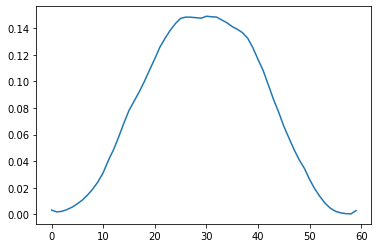

In [34]:
plt.plot(predictions.mean(0)[:,0])

# Inference

In [35]:
def inference_one(bs = 100):
    st = time.time()

    cur_epoch = getCurrentBatch()
    if cur_epoch is None: cur_epoch = 0
    print('completed epochs:', cur_epoch)

    model = TabularModel(n_cont = len(meta_cols), out_sz=360, layers=[500,200], ps=[0.5,0.5], bn_final=True)
    
    model_file_name = modelFileName(return_last=True)
    if model_file_name is not None:
        print('loading model', model_file_name)
        state_dict = torch.load(PATH_WORK/'models'/model_file_name)
        model.load_state_dict(state_dict)
    
    if (not CLOUD) or CLOUD_SINGLE:
        model = model.to(device)
    else:
        model_parallel = dp.DataParallel(model, device_ids=devices)

    setSeeds(SEED + cur_epoch)

    tst_ds = RSNA_DataSet(test_md, test_ids_df, mode='test', bs=bs)
    loader_tst = D.DataLoader(tst_ds, num_workers=8 if CLOUD else 0, batch_size=bs, shuffle=False)
    print('dataset test:', len(tst_ds), 'loader test:', len(loader_tst))

    if CLOUD and (not CLOUD_SINGLE):
        results = model_parallel(test_loop_fn, loader_tst)
        predictions = np.concatenate([results[i][0] for i in range(MAX_DEVICES)])
        indices = np.concatenate([results[i][1] for i in range(MAX_DEVICES)])
        offsets = np.concatenate([results[i][2] for i in range(MAX_DEVICES)])
    else:
        predictions, indices, offsets = test_loop_fn(model, loader_tst, device)

    predictions = predictions[np.argsort(indices)]
    offsets = offsets[np.argsort(indices)]
    assert len(predictions) == len(test_md.SeriesInstanceUID.unique())
    assert np.all(indices[np.argsort(indices)] == np.array(range(len(predictions))))
    
    print('test processing time:', time.time() - st)
    
    return predictions, offsets

In [36]:
DATA_SMALL = False
predictions, offsets = inference_one()

completed epochs: 12
loading model model.b12.f0.v21
adding dummy serieses 186
dataset test: 2400 loader test: 24
test processing time: 30.5324866771698


In [37]:
predictions.mean((0,1))

array([0.07360154, 0.00248027, 0.02532088, 0.01589688, 0.02495101,
       0.03034116], dtype=float32)

In [70]:
predictions.mean((0,1))

array([0.087846, 0.004184, 0.029325, 0.030316, 0.041098, 0.029221], dtype=float32)

In [38]:
sub = pd.DataFrame()
for i, series_id in enumerate(test_md.SeriesInstanceUID.unique()):
    df = test_md.loc[test_md.SeriesInstanceUID == series_id]
    id_column = [a + '_' + b for a in df.SOPInstanceUID for b in all_ich]
    assert (offsets[i] + len(df)) <= 60
    data_sub = pd.DataFrame({'ID':np.array(id_column), 
                             'Label':predictions[i,offsets[i]:(offsets[i] + len(df))].reshape(-1)})
    sub = pd.concat([sub,data_sub], axis=0, sort=False)

sub = sub.reset_index(drop=True)

assert len(sub) == 6*len(test_md)

In [39]:
sub.loc[range(0,len(sub),6), 'Label'].mean()

0.12431878596544266

In [40]:
best_sub = pd.read_csv(PATH/'submission_061.csv')

In [41]:
best_sub.loc[range(0,len(sub),6), 'Label'].mean()

0.13475628267250275

In [42]:
sub.to_csv(PATH/'sub.csv', index=False)

In [43]:
np.corrcoef(sub.sort_values('ID').reset_index(drop=True).loc[range(0,len(sub),6), 'Label'], 
            best_sub.sort_values('ID').reset_index(drop=True).loc[range(0,len(sub),6), 'Label'])[0,1]

0.9794069716228754

In [45]:
!kaggle competitions submit rsna-intracranial-hemorrhage-detection -f sub.csv -m "TPU"

Traceback (most recent call last):
  File "/anaconda3/envs/torch-xla-nightly/bin/kaggle", line 10, in <module>
    sys.exit(main())
  File "/anaconda3/envs/torch-xla-nightly/lib/python3.6/site-packages/kaggle/cli.py", line 51, in main
    out = args.func(**command_args)
  File "/anaconda3/envs/torch-xla-nightly/lib/python3.6/site-packages/kaggle/api/kaggle_api_extended.py", line 545, in competition_submit_cli
    competition, quiet)
  File "/anaconda3/envs/torch-xla-nightly/lib/python3.6/site-packages/kaggle/api/kaggle_api_extended.py", line 496, in competition_submit
    content_length=os.path.getsize(file_name),
  File "/anaconda3/envs/torch-xla-nightly/lib/python3.6/genericpath.py", line 50, in getsize
    return os.stat(filename).st_size
FileNotFoundError: [Errno 2] No such file or directory: 'sub.csv'
